In [6]:
#define class with useful functions relating to distribution of colloids
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

#define class with input parameters, ya0,ya1,yb0,yb1 correspond to boundary conditions
class ColloidDistribution:
    def __init__(self,D_c,u,I,D_n,ya0,ya1,yb0,yb1):
        self.D_c=D_c
        self.u=u
        self.I=I
        self.D_n=D_n
        self.ya0=ya0
        self.ya1=ya1
        self.yb0=yb0
        self.yb1=yb1
        
#function to solve coupled ODEs    
    def solveODEs(self):
        def rightsideODE(x,G):
            return np.vstack([
                G[2],
                G[3],
                (self.u/self.D_c)*G[2],
                ((1/self.D_n)*(self.u+((self.I*G[2])/G[0])))*G[3]+self.I*G[1]*(((-1/G[0]**2)*(G[2]**2))+((1/G[0])*(self.u/self.D_c)*G[2]))
            ])
        def bc(ya,yb):
            return np.array([
                ya[0]-self.ya0,
                ya[1]-self.ya1,   
                yb[0]-self.yb0,
                yb[1]-self.yb1     #Dirichlet boundary conditions show good accumulation
            ])
        x=np.linspace(0,1,1000)
        y_guess = np.ones((4, x.size)) 
        sol=solve_bvp(rightsideODE, bc, x, y_guess,max_nodes=100000)
        return sol

#plot the ODEs    
    def plotODEs(self, sol): 
        x=np.linspace(0,1,1000)  
        C=sol.sol(x)[0]
        N=sol.sol(x)[1]
        dCdx=sol.sol(x)[2]
        dNdx=sol.sol(x)[3]
        #plot C,N,dCdx,dNdx
        plt.figure()
        plt.plot(x,C,'r',label='C')
        plt.plot(x,N,'k',label='N')
        plt.plot(x,dCdx,'r',linestyle='dashed',label='dCdx')
        plt.plot(x,dNdx,'k',linestyle='dashed',label='dNdx')
        plt.xlabel('Distance')
        plt.ylabel('Concentrations')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
        print(sol.message,sol.success)
        #plot U_dp and derivative
        plt.figure()
        U_dp=(1/C)*self.I*dCdx
        particle_v=U_dp+self.u
        U_dpDerivative=self.I*(-(dCdx**2/C**2)+(self.u*dCdx)/(self.D_c*C))  
        plt.plot(x,U_dp,'b',label='U_dp')
        plt.plot(x,U_dpDerivative,'b',linestyle='dashed',label='d(U_dp)/dX')
        plt.legend(loc='best')
        plt.grid()
        plt.xlabel('Distance')
        plt.ylabel('Diffusiophoretic Velocity & Derivative')
        plt.figure()
        plt.plot(x,particle_v,'m')
        plt.xlabel('Distance')
        plt.ylabel('Particle velocity')
        plt.grid()
        plt.show()

#find the maximum concentration of colloids and at which point this occurs
    def accumulation(self, sol):  
        x=np.linspace(0,1,1000) 
        C=sol.sol(x)[0]
        N=sol.sol(x)[1]
        dCdx=sol.sol(x)[2]
        dNdx=sol.sol(x)[3]
        print('Maximum colloid concentration is ' + str(max(N)))
        pos = np.argmax(N)
        accum_point = 0.001*pos
        print('The maximum concentration of colloids occurs at ' + str(accum_point))
        return accum_point

#returning derivatives and value of functions at position of accumulation    
    def derivatives(self, sol):
        x=np.linspace(0,1,1000) 
        C=sol.sol(x)[0]
        N=sol.sol(x)[1]
        dCdx=sol.sol(x)[2]
        dNdx=sol.sol(x)[3]
        U_dp=(1/C)*self.I*dCdx  
        U_dpDerivative=self.I*(-(dCdx**2/C**2)+(self.u*dCdx)/(self.D_c*C))
        particle_v=U_dp+self.u
        pos = np.argmax(N)
        return [C[pos], dCdx[pos], dNdx[pos], U_dp[pos], U_dpDerivative[pos],particle_v[pos]]

#testing if particle velocity at point of accumulation is equal to J_0/n_max
    def particleFlux(self, sol):
        x=np.linspace(0,1,1000)
        C=sol.sol(x)[0]
        N=sol.sol(x)[1]
        dCdx=sol.sol(x)[2]
        U_dp=(1/C)*self.I*dCdx
        particle_v=U_dp+self.u
        #print(self.ya1*particle_v[0])
        #print(self.yb1*particle_v[999])
        J0=0.5*(self.ya1*particle_v[0]+self.yb1*particle_v[999])
        pos_n=np.argmax(N)
        expected_particle_v=J0/max(N)
        pos_v=np.argmin(np.abs(particle_v - expected_particle_v))
        return expected_particle_v
        '''if pos_n==pos_v:
            print('Accumulation position matches and is: ',pos_n)
        else:
            print(f'Accumulation positions don\'t match.\n'
              f'Predicted position (by particle velocity): {0.001*pos_v}, '
              f'Actual max concentration position: {0.001*pos_n}')'''

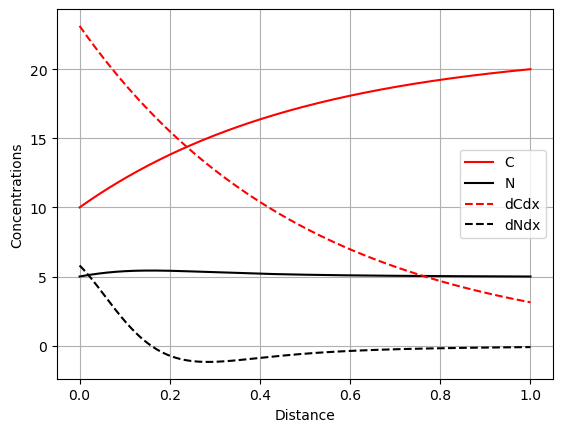

The algorithm converged to the desired accuracy. True


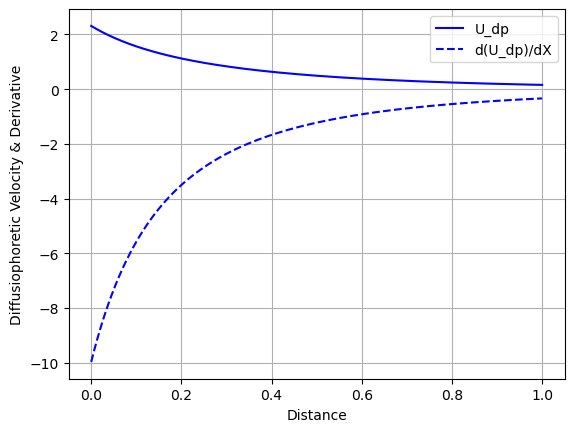

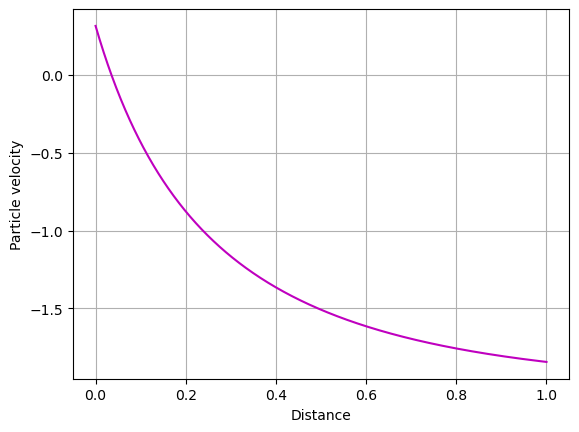

Maximum colloid concentration is 5.431430050636561
The maximum concentration of colloids occurs at 0.158
1.5651764274967372
-9.217411786251631
Accumulation positions don't match.
Predicted position (by particle velocity): 0.155, Actual max concentration position: 0.158
[13.136141923051147, 16.85806900889118, 0.004743840282093168, 1.2833348716573199, -4.21361813612635, -0.7166651283426801]


In [38]:
#test cell to check class works
expt=ColloidDistribution(1,-2,1,0.1,10,5,20,5)
sol=expt.solveODEs()
expt.plotODEs(sol)
expt.accumulation(sol)
expt.particleFlux(sol)
print(expt.derivatives(sol))

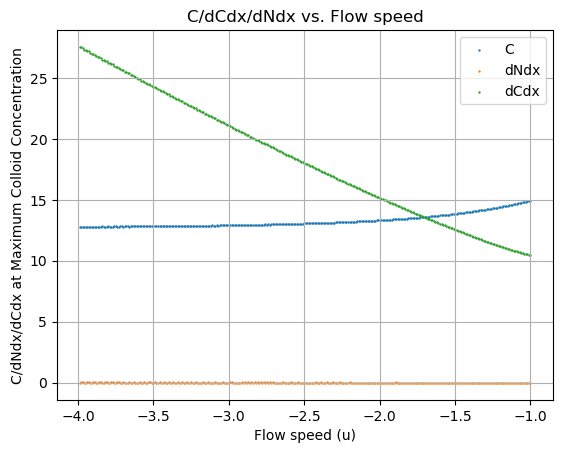

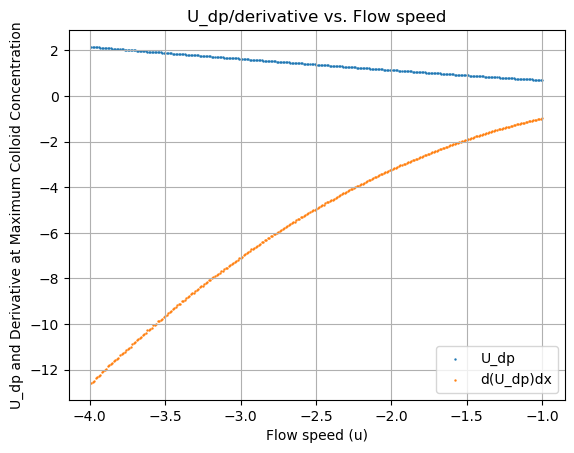

In [13]:
#investigating how derivatives at point of maximum colloid concentration change with flow speed
flow_speed=[]
C=[]
dNdx=[]
dCdx=[]
Udp=[]
UdpDerivative=[]
for i in range(300):
    expt=ColloidDistribution(1,-0.7-0.01*i,1,0.1,10,5,20,5)
    flow_speed.append(-1-0.01*i)
    solution=expt.solveODEs()
    C.append(expt.derivatives(solution)[0])
    dNdx.append(expt.derivatives(solution)[2])
    dCdx.append(expt.derivatives(solution)[1])
    Udp.append(expt.derivatives(solution)[3])
    UdpDerivative.append(expt.derivatives(solution)[4])
flow_speed=np.array(flow_speed)
C=np.array(C)
dNdx=np.array(dNdx)
dCdx=np.array(dCdx)
Udp=np.array(Udp)
UdpDerivative=np.array(UdpDerivative)
plt.figure()
plt.scatter(flow_speed, C, s=0.5,label='C')
plt.scatter(flow_speed, dNdx,s=0.5,label='dNdx')
plt.scatter(flow_speed, dCdx,s=0.5,label='dCdx')
plt.xlabel("Flow speed (u)")
plt.ylabel("C/dNdx/dCdx at Maximum Colloid Concentration")
plt.title("C/dCdx/dNdx vs. Flow speed")
plt.legend()
plt.grid()
plt.figure()
plt.scatter(flow_speed, Udp,s=0.5,label='U_dp')
plt.scatter(flow_speed, UdpDerivative,s=0.5,label='d(U_dp)dx')
plt.legend()
plt.grid()
plt.xlabel("Flow speed (u)")
plt.ylabel("U_dp and Derivative at Maximum Colloid Concentration")
plt.title("U_dp/derivative vs. Flow speed")
plt.show()

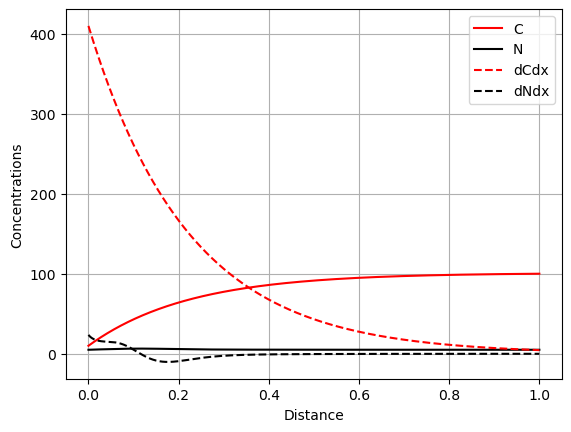

The algorithm converged to the desired accuracy. True


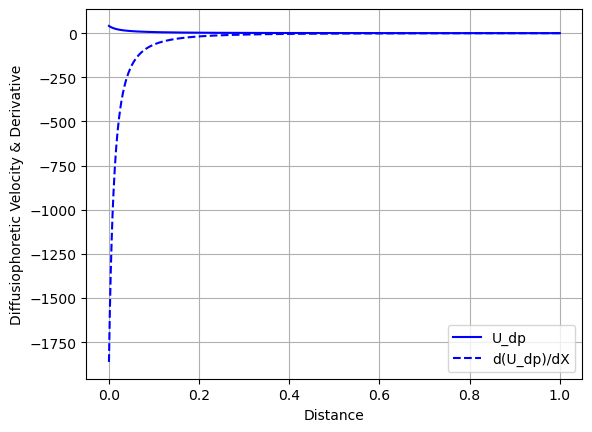

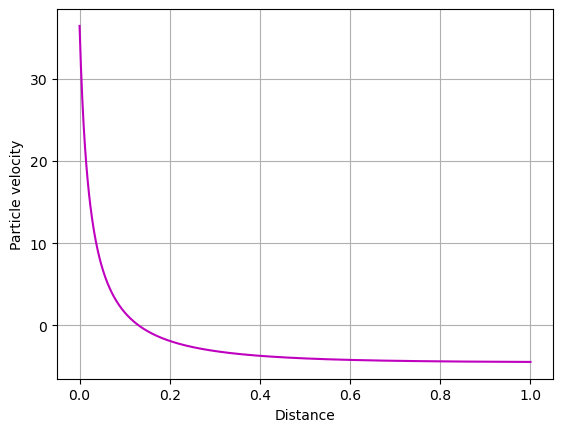

182.2748430222593
-22.27251569777408
Accumulation positions don't match.
Predicted position (by particle velocity): 0.029, Actual max concentration position: 0.115


In [42]:
#finding ratio (accumulation factor)
import random
expt=ColloidDistribution(1,-4.5,1,0.1,10,5,100,5)
sol=expt.solveODEs()
expt.plotODEs(sol)
expt.particleFlux(sol)
#as you increase diffusiophoretic mobility predicted position due to particle velocity becomes further than actual position (as accumulation is stronger)

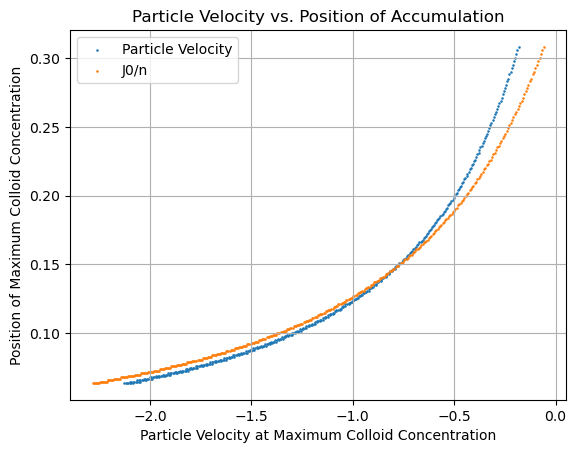

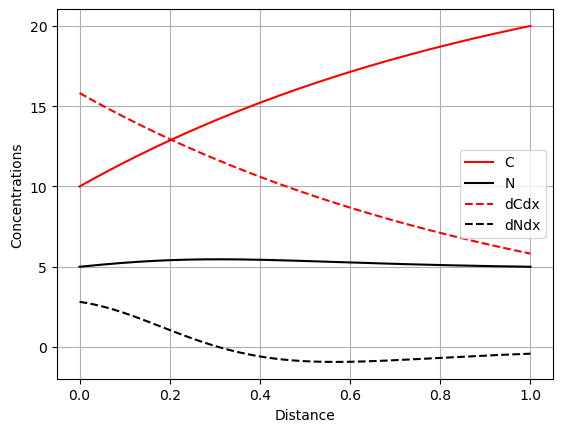

The algorithm converged to the desired accuracy. True


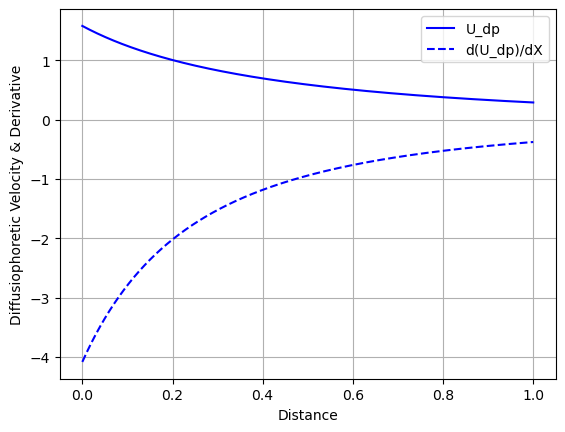

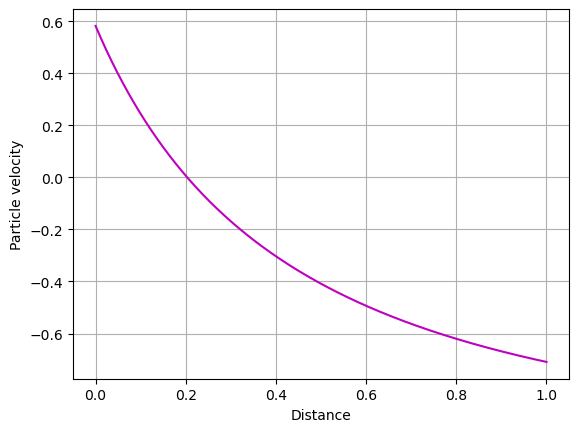

Maximum colloid concentration is 5.46553079432634
The maximum concentration of colloids occurs at 0.308


0.308

In [7]:
#plot how accumulation position changes with particle velocity at maximum conc (should equal J0/n)
particle_v=[]
pos=[]
J0Byn=[]
for i in range(400):
    expt=ColloidDistribution(1,-1-0.01*i,1,0.1,10,5,20,5)
    x=np.linspace(0,1,1000)
    sol=expt.solveODEs()
    N=sol.sol(x)[1]
    position=0.001*np.argmax(N)
    Udp=expt.derivatives(sol)[3] 
    velocity=expt.u+Udp
    particle_v.append(velocity)
    pos.append(position)
    J0Byn.append(expt.particleFlux(sol))
plt.scatter(particle_v,pos,s=0.7,label='Particle Velocity')
plt.scatter(J0Byn,pos,s=0.7,label='J0/n')
plt.xlabel('Particle Velocity at Maximum Colloid Concentration')
plt.ylabel('Position of Maximum Colloid Concentration')
plt.title('Particle Velocity vs. Position of Accumulation')
plt.legend(loc='best')
plt.grid()
run=ColloidDistribution(1,-1,1,0.1,10,5,20,5)
soln=run.solveODEs()
run.plotODEs(soln)
run.accumulation(soln)
#save this image on mac for overleaf write-up